# Knowledge Graph

Reference: https://www.analyticsvidhya.com/blog/2019/10/how-to-build-knowledge-graph-text-using-spacy/

**Import libraries**

In [2]:
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
from spacy.matcher import Matcher 
from spacy.tokens import Span 
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm
from google.colab import drive

In [3]:
nlp = spacy.load('en_core_web_sm')
pd.set_option('display.max_colwidth', 200)

**Import dataset**

In [4]:
# import wikipedia sentences
drive.mount('/content/drive')
candidate_sentences = pd.read_csv("drive/My Drive/datasets/wiki_sentences_v2.csv")
candidate_sentences.shape

Mounted at /content/drive


(4318, 1)

**Sample data**

In [6]:
# sample data
print(candidate_sentences['sentence'].sample(5))
print("---------------------------------------")
print(candidate_sentences['sentence'][:5])

154     by january 2017, johns and berg reported to emmerich.
4038                    cinematographers such as v. n. reddy,
1121                the court refused to fast-track the case.
4226                  so, dangal has not sent their entry in.
657        actors usually have their own separate call times.
Name: sentence, dtype: object
---------------------------------------
0    confused and frustrated, connie decides to leave on her own.
1               later, a woman’s scream is heard in the distance.
2                        christian is then paralyzed by an elder.
3                                      the temple is set on fire.
4                               outside, the cult wails with him.
Name: sentence, dtype: object


**Named Entity Recognization**

In [8]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

In [9]:
entity_pairs = [get_entities(i) for i in tqdm(candidate_sentences["sentence"])]


100%|██████████| 4318/4318 [00:43<00:00, 99.07it/s]


In [10]:
# Sample 
entity_pairs[10:20]

[['we', 'tests'],
 ['m global', 'international sales rights'],
 ['robbie robertson', 'soundtrack'],
 ['it', 'original music tracks'],
 ['it', 'reviewed  franchise'],
 ['she', 'accidentally  mystique'],
 ['', 'military  arrest'],
 ['train', 'vuk'],
 ['telepath', 'gallio'],
 ['singer', 'men']]

**Relationship extraction**

In [11]:
def get_relation(sent):
  doc = nlp(sent)
  # Matcher class object 
  matcher = Matcher(nlp.vocab)
  #define the pattern 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 
  matcher.add("matching_1", None, pattern) 
  matches = matcher(doc)
  k = len(matches) - 1
  span = doc[matches[k][1]:matches[k][2]] 
  return(span.text)

In [12]:
relations = [get_relation(i) for i in tqdm(candidate_sentences['sentence'])]


100%|██████████| 4318/4318 [00:43<00:00, 99.82it/s]


In [13]:
# most frequent relations
pd.Series(relations).value_counts()[:50]

is               370
was              297
released on       87
include           73
were              71
are               71
released          40
's                38
composed by       35
have              31
has               31
became            31
become            29
released in       27
included          26
called            22
produced          22
made              20
had               20
considered        20
been              18
be                18
used              17
scheduled         17
stars             16
directed by       16
written by        15
hired             14
set               14
produced by       14
wrote             14
introduced in     13
went              13
received          13
wanted            12
won               11
began             11
began in          11
features          10
sold              10
gave              10
shot in            9
reported           9
used in            9
produced in        9
opened             9
directed           9
includes     

**Building Knowledge Graph**

In [14]:
# extract subject
source = [i[0] for i in entity_pairs]
# extract object
target = [i[1] for i in entity_pairs]
kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

In [15]:
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

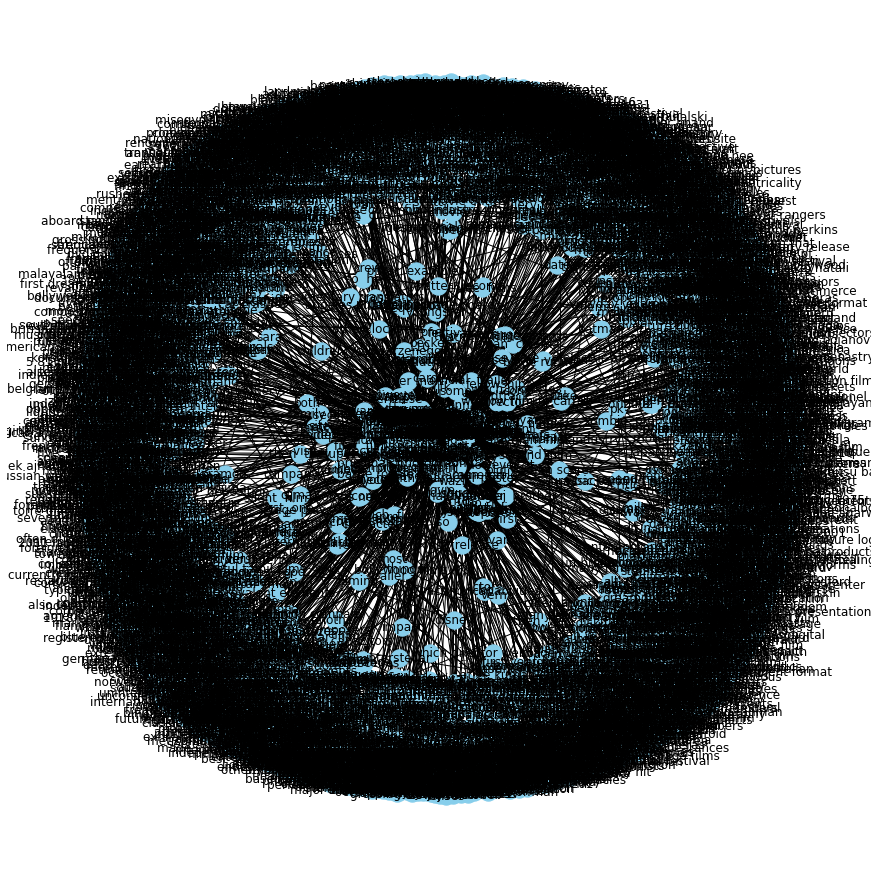

In [16]:
plt.figure(figsize=(12,12))
pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

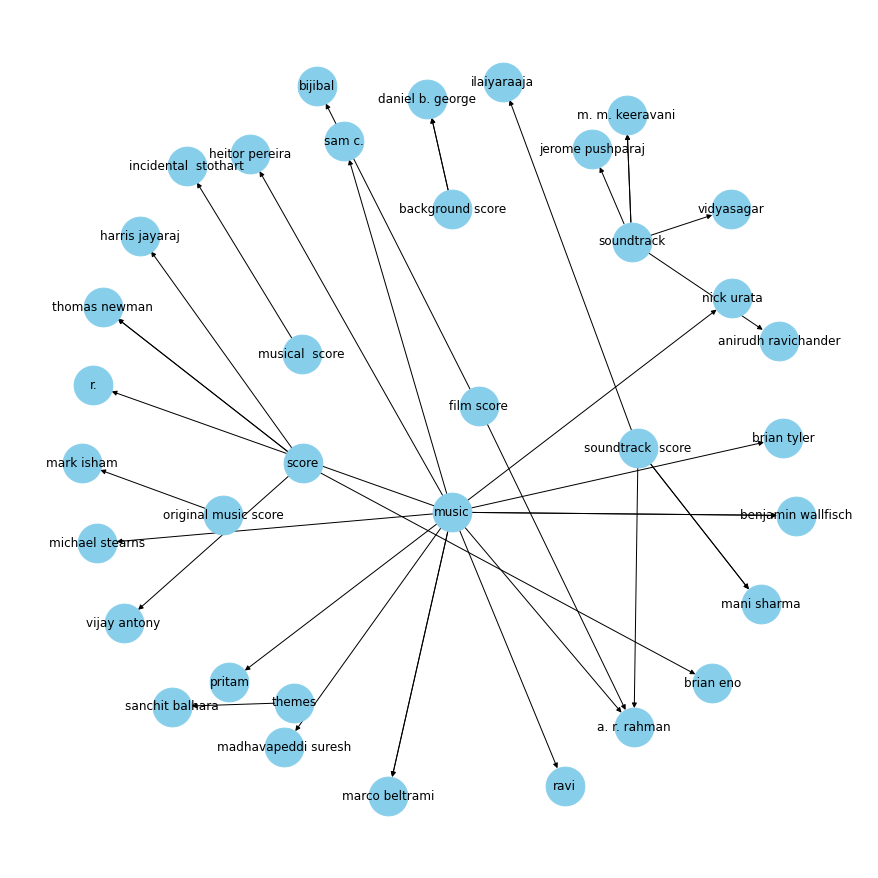

In [17]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="composed by"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

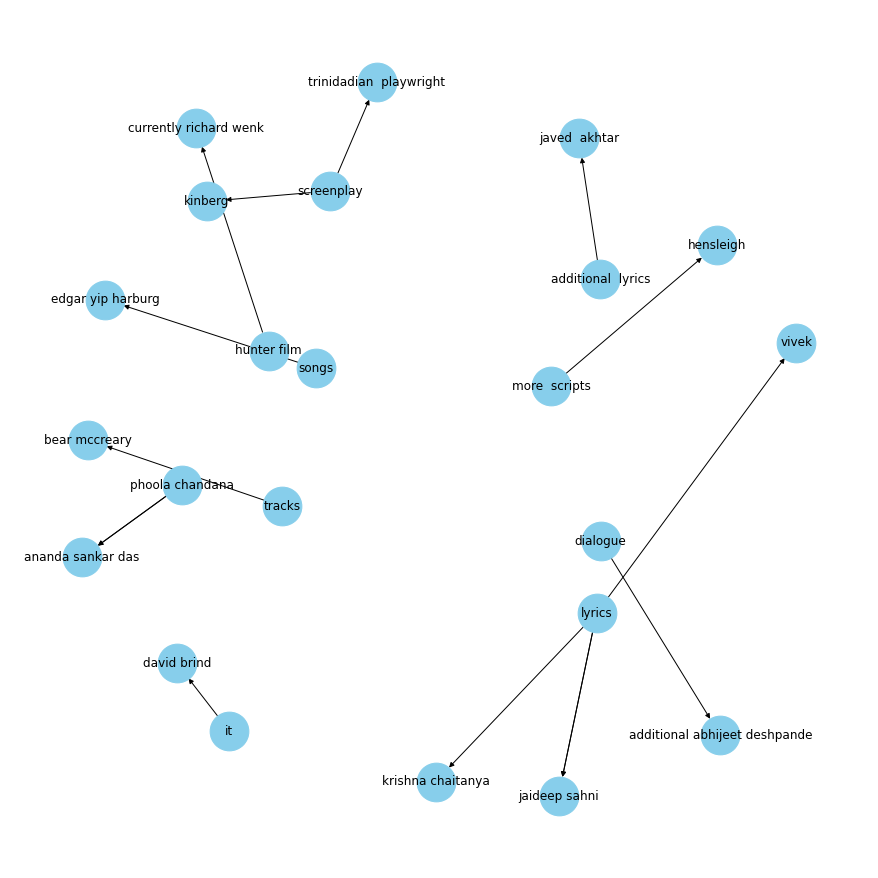

In [18]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="written by"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

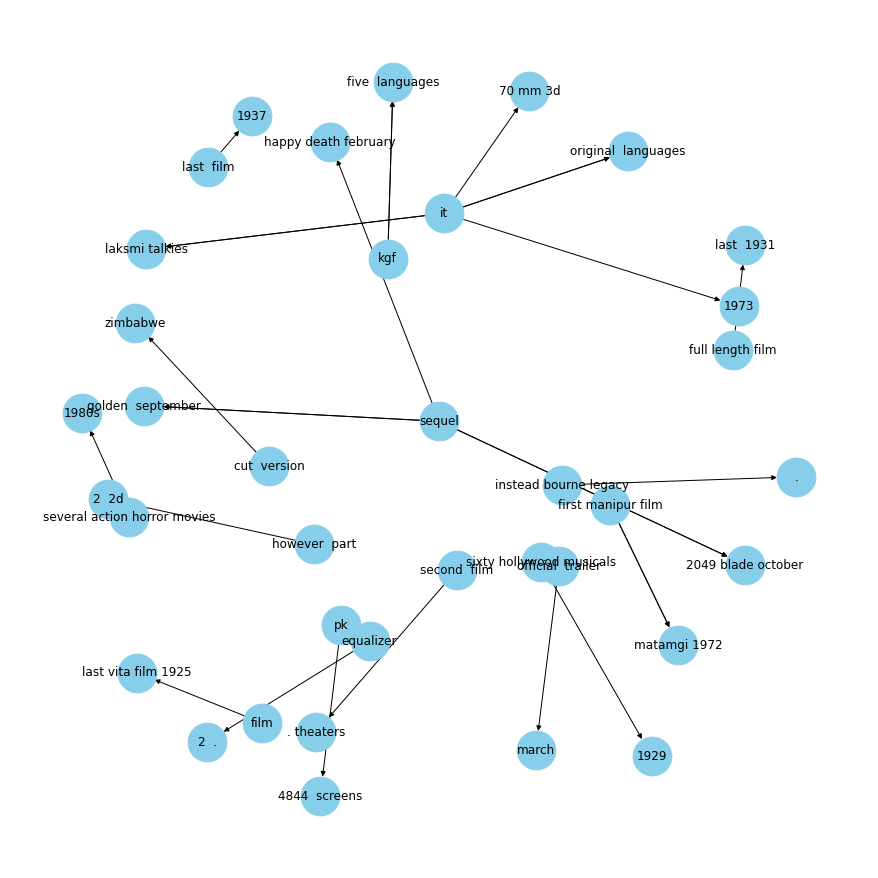

In [19]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="released in"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()